In [1]:
%matplotlib ipympl

In [2]:
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
import numpy as np
import scipy
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist, plot_bode
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import string
import pandas as pd

In [3]:
def add_noise(z,err):
    #err is the relative SD from mean value
    z_with_noise=np.random.normal(np.real(z),err*np.abs(np.real(z)))+1j*np.random.normal(np.imag(z),err*np.abs(np.imag(z)))
    return z_with_noise

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))

def give_xylim(zin,z0):
        zin_real=np.real(zin)
        zin_imag=np.imag(zin)

        z0_real=np.real(z0)
        z0_imag=np.imag(z0)

        max_0=np.maximum(np.max(z0_real),np.max(-z0_imag))
        max_in=np.maximum(np.max(zin_real),np.max(-zin_imag))

        xylim=np.maximum(max_0,max_in)
        return xylim

def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def give_SSv(zexp,zmodel,wt,num):
    #zwt=give_weights2(zmodel,wt=wt)
    zexpr=np.real(zexp)
    zmodelr=np.real(zmodel)
    zexpj=-np.imag(zexp)
    zmodelj=-np.imag(zmodel)
    if(wt=="unit" or wt==""):
       SSv=(1/(2*len(zexp)-num))*np.sum((zexpr-zmodelr)**2+(zexpj-zmodelj)**2)
    elif(wt=="mod"):
       SSv=(1/(2*len(zexp)-num))*np.sum(((zexpr-zmodelr)/np.abs(zmodel))**2+((zexpj-zmodelj)/np.abs(zmodel))**2)
    elif(wt=="prop"):
       SSv=(1/(2*len(zexp)-num))*np.sum(((zexpr-zmodelr)/(zmodelr))**2+((zexpj-zmodelj)/(zmodelr))**2)
    return SSv

def give_SS(zexp,zmodel,wt):
     #zwt=give_weights2(zmodel,wt=wt)
     #zwt=give_weights(zmodel,wt=wt)
     zexpr=np.real(zexp)
     zmodelr=np.real(zmodel)
     zexpj=-np.imag(zexp)
     zmodelj=-np.imag(zmodel)
     if(wt=="unit" or wt==""):
       SS=np.sum((zexpr-zmodelr)**2+(zexpj-zmodelj)**2)
     elif(wt=="mod"):
       SS=np.sum(((zexpr-zmodelr)/np.abs(zmodel))**2+((zexpj-zmodelj)/np.abs(zmodel))**2)
     elif(wt=="prop"):
       SS=np.sum(((zexpr-zmodelr)/(zmodelr))**2+((zexpj-zmodelj)/(zmodelr))**2)
     return SS

In [4]:
@element(num_params=5, units=["Ohm", "Ohm", "","F",""],overwrite=True)
def TLMtwoNewRQNormalRref(p, f):
   
    omega = 2 * np.pi * np.array(f)
    t1, t2, t2Q0, delta1, alpha = p[0], p[1], p[2], p[3], p[4]
    delta2=1-delta1
    Q=t2Q0/t2*1e-4
    Rref=200
    R1=Rref*t1
    R2=Rref*t2
    k12=t2/t1
    wc1=1/(R1*Q)
    wc2=1/(R2*Q)
    S1=np.sqrt((omega*1j)**alpha/wc1)
    S2=np.sqrt((omega*1j)**alpha/wc2)
    C1=1/np.tanh(delta1*S1)
    C2=1/np.tanh(delta2*S2)

    Z=2*(Rref*t1)*(C1*C2*S1*k12+S2)/(S1*(C2*S1*k12+C1*S2))

    return Z

In [5]:
@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMilinNewRQNormalRref(p,f):
    Rref=200
    omega = 2 * np.pi * np.array(f)
    t1, t2, t2Q0, alpha = p[0], p[1], p[2], p[3]
    t12=t1/t2
    Q=1e-4*t2Q0/t2
    R1=Rref*t1
    R2=Rref*t2
    wclin1=1/(R1*Q)
    wclin2=1/(R2*Q)
    S1=np.sqrt((1j*omega)**alpha/wclin1)
    S2=np.sqrt((1j*omega)**alpha/wclin2)
    
    Z = -(2*1j*R1/S1)*(((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(0,-2*1j*S1/(t12-1))))-((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(0,-2*1j*S1/(t12-1)))))/(((scipy.special.jv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.yv(1,-2*1j*S1/(t12-1))))-((scipy.special.yv(1,-2*1j*t12*S2/(t12-1)))*(scipy.special.jv(1,-2*1j*S1/(t12-1)))))
    
    return Z



In [6]:
@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMlinNew(p,f):
    Rref=200
    omega = 2 * np.pi * np.array(f)
    t1, t2, t2Q0, alpha = p[0], p[1], p[2], p[3]
    t12=t1/t2
    Q=1e-4*t2Q0/t2
    R1=Rref*t1
    S=np.sqrt((1j*omega)**alpha*R1*Q)
    kk1=-2/3*(S*(t12**(-1/2)/(t12-1)))
    kk2=-2/3*(t12*S/(t12-1))
    Z = (2*R1/S)*(scipy.special.iv(1/3, kk1)*scipy.special.iv(2/3, kk2)-scipy.special.iv(-1/3, kk1)*scipy.special.iv(-2/3, kk2))/((scipy.special.iv(-1/3, kk1))*scipy.special.iv(1/3, kk2)-scipy.special.iv(1/3, kk1)*scipy.special.iv(-1/3, kk2))
    return Z

In [7]:
@element(num_params=7, units=["Ohm", "Ohm", "Ohm", "","", "F",""],overwrite=True)
def TLMthreeNewRQNormalRref(p, f):
    omega = 2 * np.pi * np.array(f)
    t1, t2, t3,t3Q0, delta1, delta2, alpha = p[0], p[1], p[2],p[3], p[4], p[5], p[6]
    delta3=1-delta1-delta2
    delta2=delta2
    Rref=200
    Q=t3Q0/t3*1e-4
    R1=t1*Rref
    R2=t2*Rref
    R3=t3*Rref
    k12=R2/R1
    k13=R3/R1
    wc1=1/(R1*Q)
    wc2=1/(R2*Q)
    wc3=1/(R3*Q)
    S1=np.sqrt((omega*1j)**alpha/wc1)
    S2=np.sqrt((omega*1j)**alpha/wc2)
    S3=np.sqrt((omega*1j)**alpha/wc3)
    C1=1/np.tanh(delta1*S1)
    C2=1/np.tanh(delta2*S2)
    C3=1/np.tanh(delta3*S3)

    Z=2*(R1)*((S1*S3*C1*k12**2+S2*C2*(S1*C1*C3*k13+S3)*k12+S2**2*C3*k13)/(S1*(S3*S1*k12**2+S2*C2*(S3*C1+S1*C3*k13)*k12+S2**2*C1*C3*k13)))

    return Z

@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMlinzertNewSecondSecondRQNormalRref(p,f):
    
    Rref=200
    omega = 2 * np.pi * np.array(f)
    t1, t2, t2Q0, alpha = p[0], p[1], p[2], p[3]
    Q=1e-4*t2Q0/t2
    R1=Rref*t1
    eps=(t2-t1)/t1
    S=np.sqrt((R1*Q*(omega*1j)**alpha))

    #second expansion
    Z=2*4*R1*(np.exp(4*S)+2*np.exp(2*S)+1)*(np.exp(2*S)+1)*S/((((S**4-2/3*(S**3)+2*S**2-5/2*S+1/8)*eps**2+(4*S**3+S)*eps-4*S**2)*np.exp(2*S)+((-S**4-2/3*(S**3)-2*S**2-5/2*S-1/8)*eps**2+(4*S**3+S)*eps+4*S**2)*np.exp(4*S)+(4*S**2-S*eps+7/8*(eps**2))*np.exp(6*S)-4*S**2-S*eps-7*eps**2*(1/8)))
    return Z

In [8]:
freq = np.logspace(3,-3,num=100)

c_two=CustomCircuit(initial_guess=[6,2,2,0.2063,1],circuit='TLMtwoNewRQNormalRref')
c_two2=CustomCircuit(initial_guess=[2,6,6,0.2063,1],circuit='TLMtwoNewRQNormalRref')
c_three=CustomCircuit(initial_guess=[5.22,3.47,2.15,2.15,0.2,0.17,1],circuit='TLMthreeNewRQNormalRref')
c_lin=CustomCircuit(initial_guess=[4.3,3,3,1],circuit='TLMlinzertNewSecondSecondRQNormalRref')
c_ilin=CustomCircuit(initial_guess=[8,1,1,1],circuit='TLMilinNewRQNormalRref')

z_two=c_two.predict(freq)
z_two2=c_two2.predict(freq)
z_three=c_three.predict(freq)
z_lin=c_lin.predict(freq)
z_ilin=c_ilin.predict(freq)

c:\Users\Gaming\AppData\Local\Programs\Python\Python311\Lib\site-packages\impedance\models\circuits\circuits.py:145: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


In [9]:
p_two=c_two.initial_guess
t1_0=p_two[0]
t2_0=p_two[1]
t2Q0_0=p_two[2]
delta_0=p_two[3]
alpha_0=p_two[4]
Q_0=1e-4*t2Q0_0/t2_0

p_two2=c_two2.initial_guess
t1_02=p_two2[0]
t2_02=p_two2[1]
t2Q0_02=p_two2[2]
delta_02=p_two2[3]
alpha_02=p_two2[4]
Q_02=1e-4*t2Q0_02/t2_02

pf1=c_three.initial_guess
t1_f1, t2_f1, t3_f1, t3Q0_f1, delta1_f1, delta2_f1, alpha_f1 = pf1[0], pf1[1], pf1[2],pf1[3], pf1[4], pf1[5], pf1[6]
Q_f1=1e-4*t3Q0_f1/t3_f1 

pg=c_lin.initial_guess
t1_g=pg[0]
t2_g=pg[1]
t2Q0_g=pg[2]
alpha_g=pg[3]
Q_g=1e-4*t2Q0_g/t2_g

#g means lin
#f1 means three
#0 means two

pilin=c_ilin.initial_guess
t1_ilin=pilin[0]
t2_ilin=pilin[1]
t2Q0_ilin=pilin[2]
alpha_ilin=pilin[3]
Q_ilin=1e-4*t2Q0_ilin/t2_ilin

#pf2 means ilin

c:\Users\Gaming\AppData\Local\Programs\Python\Python311\Lib\site-packages\impedance\visualization.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)


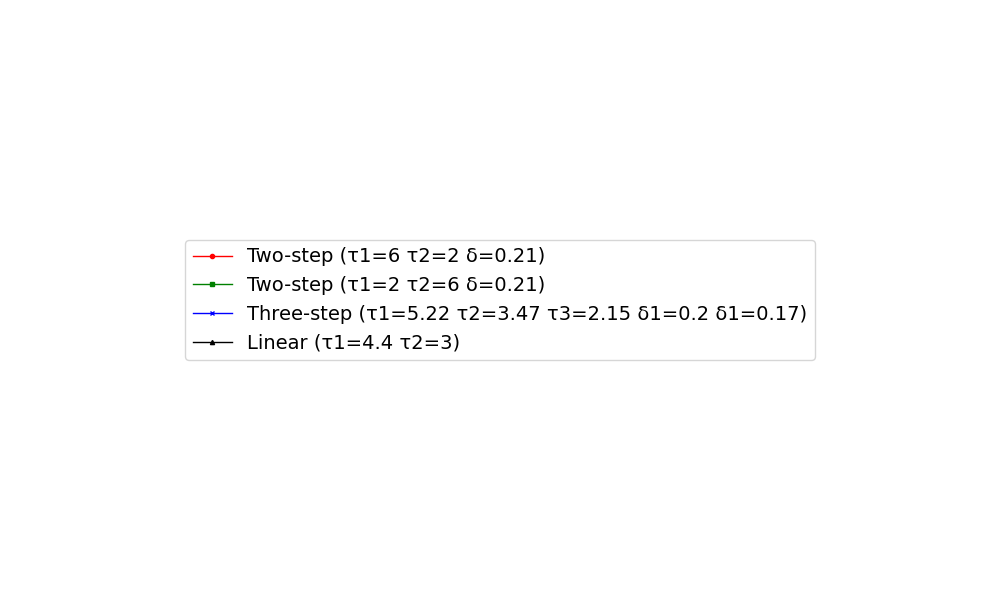

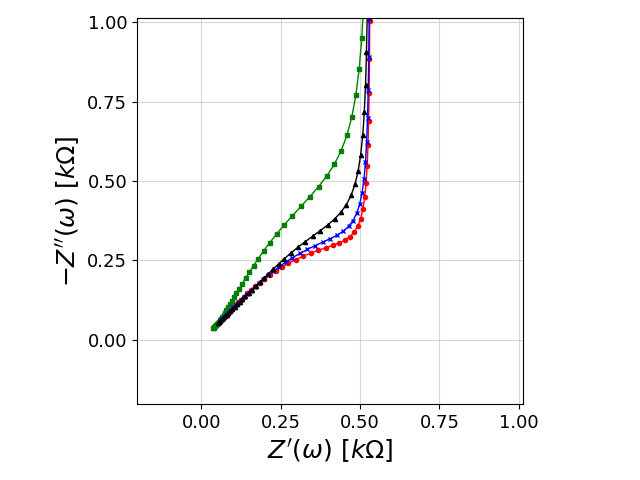

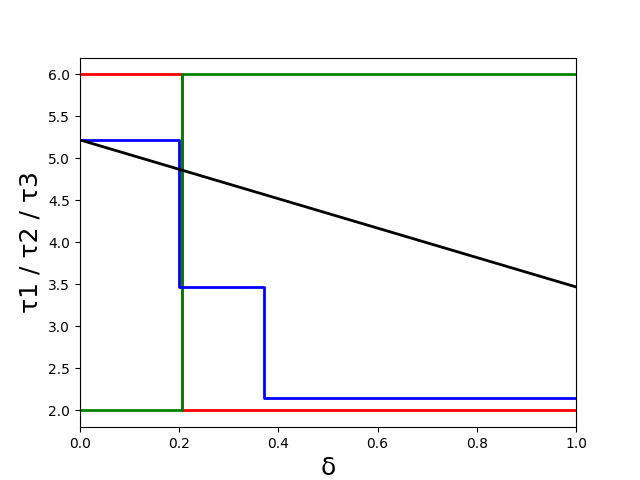

In [10]:
xylim=max(give_xylim(z_two,z_three),give_xylim(z_lin,z_ilin))

if xylim%1000>=1:
    units="kΩ"
    factor=1000
else:
    units="Ω"
    factor=1
alpha=0.3
#nyquist plot 
#ax2=fig.add_subplot(1,2,2)
# ax2=plt.subplot2grid((5,4),(1,2),colspan=2,rowspan=4)
fgg,ax2=plt.subplots()
Rref=200
f_c=1/(Rref*t1_0*Q_0)
idx=find_index_of_nearest(freq,f_c)
z_c=c_three.predict([freq[idx]])
xylim=2*np.real(z_c)
ax2.set_xlim(0,xylim/factor)
ax2.set_ylim(0,xylim/factor)
#ax2.text(-0.1, 1.05, "(B)", transform=ax2.transAxes, size=10, weight='bold')
color_actual="red"
color_noise1="red"
color_noise2="green"
color_noise3="blue"
color_noise4="black"
color_fitted1=color_noise1
color_fitted2=color_noise2
color_fitted3=color_noise3
color_fitted4=color_noise4
ax2.set_xlim(-0.2*xylim/factor,xylim/factor)
ax2.set_ylim(-0.2*xylim/factor,xylim/factor)
# plot_nyquist(zin1/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
# plot_nyquist(zin2/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
# plot_nyquist(zin3/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
plot_nyquist(z_two/factor,ax=ax2,units=units,labelsize=18,ticksize=13,color=color_fitted1,linewidth=1,marker="o",ms=3,label="Two-step (τ1=6 τ2=2 δ=0.21)")
plot_nyquist(z_two2/factor,ax=ax2,units=units,labelsize=18,ticksize=13,color=color_fitted2,linewidth=1,marker="s",ms=3,label="Two-step (τ1=2 τ2=6 δ=0.21)")
plot_nyquist(z_three/factor,ax=ax2,units=units,labelsize=18,ticksize=13,color=color_fitted3,linewidth=1,marker="x",ms=3,label="Three-step (τ1=5.22 τ2=3.47 τ3=2.15 δ1=0.2 δ1=0.17)")
# plot_nyquist(zf3/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
plot_nyquist(z_lin/factor,ax=ax2,units=units,labelsize=18,ticksize=13,color=color_fitted4,linewidth=1,marker="^",ms=3,label="Linear (τ1=4.4 τ2=3)")
# plot_nyquist(z_ilin/factor,ax=ax2,units=units,labelsize=18,ticksize=13,color=color_fitted4,linewidth=1,marker="s",ms=3,label="Inverse-Linear")
#ax2.legend()
plt.tight_layout()
plt.savefig("nyquist plots.png",format="png",dpi=1200)

fgg2,ax3=plt.subplots()
ax3.plot([0,delta_0,delta_0,1],[t1_0,t1_0,t2_0,t2_0],linewidth=2,color=color_fitted1,label="Two-step")
ax3.plot([0,delta_02,delta_02,1],[t1_02,t1_02,t2_02,t2_02],linewidth=2,color=color_fitted2,label="Two-step 2")
ax3.plot([0,delta1_f1,delta1_f1,delta2_f1+delta1_f1,delta2_f1+delta1_f1,1],[t1_f1,t1_f1,t2_f1,t2_f1,t3_f1,t3_f1],linewidth=2,color=color_fitted3,label="Three Step")
ax3.plot([0,1],[t1_f1,t2_f1],linewidth=2,color=color_fitted4,label="Linear")
ax3.set_xmargin(0)
ax3.set_ylabel("τ1 / τ2 / τ3",fontsize=18) 
ax3.set_xlabel("δ",fontsize=18)
plt.savefig("profiles plots.png",format="png",dpi=1200)


figsize = (10, 6)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend(*ax2.get_legend_handles_labels(), loc='center',fontsize=14)
for line in ax_leg.get_lines():
   line.set_linewidth(9)
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.savefig(f"night3 legend fig t1={t1_0} t2={t2_0} δ={delta_0}.png",format="png",dpi=1200)
plt.tight_layout()
plt.show()